# 💬 EXP 12.  한국어 데이터로 챗봇 만들기 


* 이번 시간에는 트랜스포머 모델에 대해 배워보고, 실습을 통해 `Cornell Movie-Dialogs Corpus ` 라는 영화 및 tv 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 전처리하고, 문장을 입력하면 그에 맞는 단어를 출력하는 챗봇을 만들어보았다.


* 실습을 토대로 한국어 데이터셋을 가져와 한국어 문장을 주면, 알맞은 한국어 문장을 출력 해 주는 챗봇을 만들어보겠습니다. 



----




# 루브릭 평가 기준 


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다. | 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다. |
| 2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. | 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다. |
| 3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. | 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다 |



----



# 목차


## 1. 데이터 수집하기


## 2. 데이터 전처리 하기


## 3. SubwordTextEncoder 사용하기


## 4. 모델 구성하기


## 5. 모델 평가하기


## 회고!


## 🖇️ 참고 페이지



----



# 시작하기 전에, 필요한 모듈 불러오기!

In [277]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os, re, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


# 1. 데이터 수집하기
 

## &nbsp;&nbsp; 1-1 데이터 가져오기 


* 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.  
  이 데이터는 [<링크>](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)에서 다운로드할 수 있습니다.
  

* 클라우드를 이용할 땐, 아래 명령어를 입력 해 줍니다

In [278]:
# $ mkdir -p ~/aiffel/transformer_chatbot/data/
# $ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [279]:
dataset_filepath = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## &nbsp;&nbsp; 1-2 데이터셋 확인하기 


* 이번시간에 사용해 볼 데이터셋을 확인 해 봅시다. 
* 실습 데이터와는 다르게, 한국어 데이터셋은 한 파일에 질문과 대답이 같이 들어있단 점을 명심합니다. 

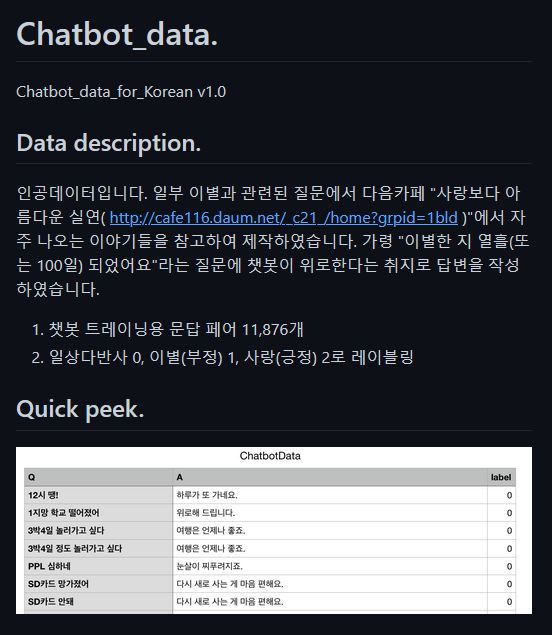  


* 데이터셋은 총 11,876개의 **문답 페어**로 이루어졌다. 
* label : 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링 = 총 3종 

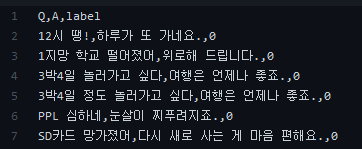  

질문 , 대답 , 라벨링. 위 그림처럼 이루어진 데이터셋이다. 
* 실습에서 썼던 데이터셋에 비해 데이터의 양이 많지 않아, 샘플의 최대 개수는 12,000개로 잡아주겠습니다. 

In [280]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 12000
print(MAX_SAMPLES)

12000




---




# 2. 데이터 전처리 하기


* 이번 노드에선, 함수화 해서 처리했던 부분이 유독 많았는데, 함수의 기능을 하나하나 살펴보면서, 데이터 전처리 작업을 진행하겠습니다.


* 영문이였던 예제 데이터와는 달리, 지금 다뤄볼 것은 한국어 데이터이므로, 전처리 과정에서 신경써야 할 것을 짚어보고, 데이터를 전처리 해 줍시다. 



## &nbsp;&nbsp; 2-1 정규 표현식 - 문장끝 구두점 제거 


* 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제합니다.
* 단어와 구두점 사이에 공백을 집어넣어준 다음, 정규표현식 안의 제외한 모든 문자를 공백 '  ' 으로 대체해줍니다.
* 숫자도 포함해 줍니다. (ex) 1박 2일, 1지망 학교 
* 한국어 데이터도 남겨주어야 하니, 정규표현식에 한국어 단어도 포함시켜줍니다.   
  단, 자음이나 모음만 있는 데이터는 학습에 방해 될 것같다 판단하여 정규표현식에 추가하지 않았습니다.  

In [281]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣\d?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print("전처리 함수가 만들어졌어요!")

전처리 함수가 만들어졌어요!


## &nbsp;&nbsp; 2-2 데이터를 불러오고, 질답 데이터를 전처리


* 2-1 에서 만들었던 전처리 함수와 함께 데이터를 불러오는 기능을 추가해, 데이터를 불러와, 전처리까지 같이 해 주는 함수를 만듭니다.
* `load_conversations`부분은 김유식님의 프로젝트를 참고하여 주석처리 하였습니다만, next 부분이 아직도 이해되지않아.. 무슨 메커니즘으로 저렇게 된거지? 

In [282]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    # 위에서 지정한 데이터셋 경로를 가져와 데이터를 불러옵니다.
    with open(dataset_filepath, errors='ignore') as file:
        lines = file.readlines()
        
    inputs, outputs = [], []# 질문과 대답 데이터를 담기 위한 각각의 리스트 
    with open(dataset_filepath) as file: # file = open(dataset_filepath)
        lines = csv.reader(file) 
        next(lines) #lines를 순서대로 불러온다? 
        for line in lines:
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs

In [283]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [284]:
print('전처리 후의 5번째 질문 샘플: {}'.format(questions[1]))
print('전처리 후의 5번째 답변 샘플: {}'.format(answers[1]))

전처리 후의 5번째 질문 샘플: 1지망 학교 떨어졌어
전처리 후의 5번째 답변 샘플: 위로해 드립니다 .




---




# 3. SubwordTextEncoder 사용하기


1. TensorFlow Datasets **SubwordTextEncoder**를 토크나이저로 사용한다.
단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 **정수로 인코딩**한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는
`START_TOKEN` 및 `END_TOKEN`을 추가한다.
3. 최대 길이 **MAX_LENGTH**인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 **패딩** 한다.

## &nbsp;&nbsp; 3-1 단어장 만들기 


- 우선 각 단어에 고유한 정수 인덱스를 부여하기 위해 단어장을 만듭니다.
- 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [285]:

print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


## &nbsp;&nbsp; 3-2 단어장 만들기 


* 디코더의 문장 생성 과정에서 사용할  ‘시작 토큰’과 ‘종료 토큰’에 대해서도 임의로 단어장에 추가하여 정수를 부여해줍니다.

In [286]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [287]:
# 부여한 정수를 출력 해 봅시다 
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8162]
END_TOKEN의 번호 : [8163]


* 현재 단어장의 크기가 8162번 (0번부터 8162번) 이란걸 알 수 있습니다. 


* 2개의 토큰을 추가해 주었기 때문에, 단어장의 크기도 +2가 되야 한단 사실을 까먹지 말것! 

In [288]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8164


## &nbsp;&nbsp; 3-3 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)


- 단어장을 만들었으니,
    - `tokenizer.encode()`
        - 각 단어를 정수로 변환할 수도 있고,
    - `tokenizer.decode()`
        - 정수 시퀀스를 단어 시퀀스로도 변환할 수 있다.
        
- 5번째 샘플을 tokenizer.encode() 의 입력으로 사용해서 변환 결과를 확인 해봅니다.

In [289]:
# 임의의 5번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 5번째 질문 샘플: {}'.format(tokenizer.encode(questions[5])))
print('정수 인코딩 후의 5번째 답변 샘플: {}'.format(tokenizer.encode(answers[5])))


정수 인코딩 후의 5번째 질문 샘플: [8021, 8006, 2188, 916, 78, 817]
정수 인코딩 후의 5번째 답변 샘플: [69, 2062, 455, 5, 137, 2184, 17, 1]


* 패딩 하기 전에, 패딩에 필요한 함수를 가져옵니다. 

In [290]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

print("슝=3")

슝=3


In [291]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [292]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


In [293]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [294]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


* 질문 셋과 답변 셋에 대해서 전부 정수 인코딩을 해 줍시다. + 최대길이를 정하고, 길이만큼 패딩까지 해 줍니다. 

In [295]:
# 최대 허용 길이 지정
MAX_LENGTH = 15

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 15 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 15으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


* 정수 인코딩 과정을 수행하면서 길이가 40을 넘는 샘플은 필터링되었기 때문에 제외되었습니다.
* 정수 인코딩, 패딩 과정을 거친 샘플 갯수, 단어장의 개수를 확인 해봅니다.


In [296]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11571
필터링 후의 답변 샘플 개수: 11571


* 샘플 인코딩, 패딩 적용 전/후 샘플 개수 비교 
| 크기(개수) | 적용 전 | 적용 후 |
| --- | --- | --- |
| 단어장 | 8164 | 8164 |
| 질문 샘플  | 11823 | 11571 |
| 답변 샘플  | 11823 | 11571 |

## &nbsp;&nbsp; 3-4 교사 강요(Teacher Forcing) 사용하기


* 교사 강요는 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법 입니다. 
* 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용한다 합니다. 
* 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다.
    - 교사 강요를 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용합니다. 

In [297]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("슝=3")


슝=3




---




# 4. 모델 구성하기

## &nbsp;&nbsp; 4-1 인코더 만들기


* 2개의 서브층으로 나눠진 인코더층을 만들었습니다. 2개의 서브층에는 셀프 어텐선과 피드 포워드 신경망이 포함되어 있습니다. 
* 인코더 층을 쌓아 인코더 함수를 만들어봅니다. 

In [298]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [299]:
# 인코더 층을 쌓아 인코더 함수를 만듭니다.
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## &nbsp;&nbsp; 4-2 디코더 만들기


- 이렇게 구현한 디코더의 층은 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다. 
- 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓음.
- 쌓은 디코더 층으로 디코더 함수를 만듭니다.


In [300]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )
print("슝=3")

슝=3


In [301]:
# 디코더 층을 쌓아 디코더를 만듭니다.
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )
print("슝=3")

슝=3


## &nbsp;&nbsp; 4-3 트랜스포머 함수 정의하기 


- 위에서 만든 인코더층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

In [302]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
        output_shape=(1, 1, None),
        name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## &nbsp;&nbsp; 4-4 모델 생성하기 

In [303]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3144192     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## &nbsp;&nbsp; 4-5 손실함수 

- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [304]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


## &nbsp;&nbsp; 4-6 커스텀 된 학습률(Learning rate)

- 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
    - 모델학습 초기에 learning rater를 급격히 높혔다가, train step이 진행됨에 따라 서서히 
    낮추어 가면서 안정적으로 수렴하게 하는 고급 기법.

In [305]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

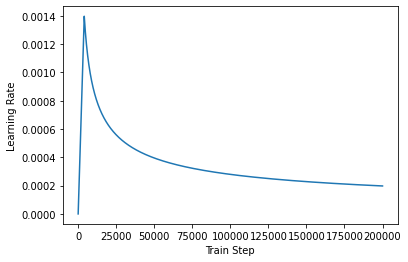

In [306]:
# 커스텀된 학습률을 시각화 해 봅니다.
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


## &nbsp;&nbsp; 4-7 모델 컴파일 


* 손실 함수와 커스텀 된 학습률을 사용하여 모델을 컴파일합니다.

In [307]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


## &nbsp;&nbsp; 4-8 모델 훈련하기


* epoch = 50만큼 모델 학습을 진행 해 봅니다. 

In [308]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
181/181 [==============================] - 11s 33ms/step - loss: 3.9481 - accuracy: 0.0801
Epoch 2/50
181/181 [==============================] - 6s 33ms/step - loss: 3.2081 - accuracy: 0.1376
Epoch 3/50
181/181 [==============================] - 6s 33ms/step - loss: 2.7224 - accuracy: 0.1407
Epoch 4/50
181/181 [==============================] - 6s 33ms/step - loss: 2.5095 - accuracy: 0.1505
Epoch 5/50
181/181 [==============================] - 6s 32ms/step - loss: 2.3540 - accuracy: 0.1595
Epoch 6/50
181/181 [==============================] - 6s 33ms/step - loss: 2.1898 - accuracy: 0.1714
Epoch 7/50
181/181 [==============================] - 6s 33ms/step - loss: 2.0122 - accuracy: 0.1873
Epoch 8/50
181/181 [==============================] - 6s 33ms/step - loss: 1.8164 - accuracy: 0.2079
Epoch 9/50
181/181 [==============================] - 6s 33ms/step - loss: 1.6065 - accuracy: 0.2317
Epoch 10/50
181/181 [==============================] - 6s 33ms/step - loss: 1.3879 - accur



---




# 5. 모델 평가하기


* 만든 모델을 평가 해 봅시다. 예측 단계 과정을 담은 함수와, 챗봇의 대답을 얻을 수 있는 함수를 만듭니다.
* 질문을 입력해, 모델의 대답을 들어봅시다:D


## &nbsp;&nbsp; 5-1 예측 단계 과정을 담은 함수 만들기 


- 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.
    1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
    3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
    4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
    5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
    6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
    
    
* 위 과정을 모두 담은 함수를 만듭니다. 

In [313]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    return tf.squeeze(output_sequence, axis=0)

print("슝=3")

슝=3


## &nbsp;&nbsp; 5-2 챗봇의 대답을 얻는 함수 만들기 


In [314]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('질문 : {}'.format(sentence))
    print('대답 : {}'.format(predicted_sentence))

    return predicted_sentence
print("슝=3")

슝=3


## &nbsp;&nbsp; 5-3 챗봇의 대답을 얻어 볼까요?


* 여러가지 문장을 리스트에 담아 챗봇의 대답을 확인 해 봅시다. 
* 단어만 넣었을 땐, 어떤 대답을 하는지 궁금해졌다 

In [343]:
#문장 리스트 
sentense_list = ['밥먹었니?','오늘 기분은 어때?','너의 마음에 우산이 되어줄께','오늘 점심 뭐 먹을래?',
                '학습이 잘 된것 같니?','잘 잤어?','한 말씀 해 주시죠!','티비를 켰더니 네가 나오더라. 잘 지내니?',
                '파란 나라를 보았니?', '학교다녀오겠습니다']

# 단어 리스트 
voca_list = ['태극기', '전화기', '피자', '운동', '앵무새']

# 숫자가 포함된 단어 
countable_list = ['1권', '5명', '다섯마리', '5일장', '10년 묵은 체증']

# 숫자가 포함된 문장 
coun_sent_list = ['사과 다섯개를 샀어요','오늘은 5일장에 다녀왔어요!', '나 2박 3일로 강원도에 놀러갈거야.']


In [340]:
# 리스트 내 문장, 단어를 연속으로 가져오는 함수를 만들었습니다. 
def talking(listt) :
    for i in range(len(listt)):
        sentence_generation(listt[i])
        print('')

In [345]:
# 단어 리스트에 대한 챗봇의 대답 
talking(voca_list)

질문 : 태극기
대답 : 하나씩 치워보세요 .

질문 : 전화기
대답 : 현실을 받아들이는 것도 중요합니다 .

질문 : 피자
대답 : 너무 시작이 반이에요 . 어서 준비하세요 .

질문 : 운동
대답 : 운동을 함께 해보세요 .

질문 : 앵무새
대답 : 이젠 그녀를 놓아주세요 .



In [346]:
# 숫자가 포함된 단어 리스트에 대한 챗봇의 대답 
talking(countable_list)

질문 : 1권
대답 : 사귀고 나서 간섭 가능합니다 .

질문 : 5명
대답 : 많이 답답할 거라 생각해요 .

질문 : 다섯마리
대답 : 하나씩 보내주세요 .

질문 : 5일장
대답 : 좋은 곳으로 데려다 줄 거예요 .

질문 : 10년 묵은 체증
대답 : 더 많이 연락하고 관심을 가져주세요 .



In [348]:
# 문장리스트에 대한 챗봇의 대답 
talking(sentense_list)

질문 : 밥먹었니?
대답 : 배고프지 않아요 .

질문 : 오늘 기분은 어때?
대답 : 좋았으면 좋겠네요 .

질문 : 너의 마음에 우산이 되어줄께
대답 : 한번 말해보세요 .

질문 : 오늘 점심 뭐 먹을래?
대답 : 맛있는 거 드세요 .

질문 : 학습이 잘 된것 같니?
대답 : 환승은 30분 안에

질문 : 잘 잤어?
대답 : 피곤했나봐요 .

질문 : 한 말씀 해 주시죠!
대답 : 지금이라도 효도하세요 .

질문 : 티비를 켰더니 네가 나오더라. 잘 지내니?
대답 : 마음에 드는 책을 잘 찾아보세요 .

질문 : 파란 나라를 보았니?
대답 : 많이 내리길 바라요 .

질문 : 학교다녀오겠습니다
대답 : 충분히 좋은 사람 만날 수 있을 거예요 .



In [344]:
# 숫자가 포함된 문장 리스트에 대한 챗봇의 대답 
talking(coun_sent_list)

질문 : 사과 다섯개를 샀어요
대답 : 나쁜 사람이네요 .

질문 : 오늘은 5일장에 다녀왔어요!
대답 : 맛있게 드세요 .

질문 : 나 2박 3일로 강원도에 놀러갈거야.
대답 : 그분은 마음의 정리를 했나봐요 .



* 질문에 알맞은 대답이 돌아온 문장도 있지만, 엉뚱한 대답이 돌아온 부분도 많다. 대체적으로 문장부호를 함께 붙인 질문에 그나마 적절한 대답이 돌아온 것 같다.

* 단어만 넣었을 땐, 앞 뒤 문맥이 없어 단어에 대한 문장을 제대로 유추하지 못 한것같다. 적어도 단어에 관련한 문장을 출력하길 바라고 리스트를 만들었었다. 하지만 정확도가 50%도 넘지 않는 모델에게 너무 많은 걸 요구하지 않았나 싶다.



---




# 회고!

* 이번 노드도 어렵고 재미있었다^^..... 

*  load_conversations() 함수 생성 과정에서 잘 진행되지 않아, 강양인 김유식님 프로젝트를 보면서 이해 해 봤다. 
   특히나 원본 코드 중 `  line.replace('\n', '').split(' +++$+++ ') `    부분이 이해되지 않아 나름대로 생각 해봤는데, 줄바꿈을 위한 코드였지만, 우리 문장엔 줄 바꿈이 필요없어 사용하지 않으셨을까? 하고 추측해 봤다. 

* 또한, next(lines)를 사용하셔서 lines를 순서대로 불러 와 주셨던것 같은데, 어떤 매커니즘으로 작동 됬는지는 아직도 의문이다. 좀 더 공부 해 봐야겠다.
   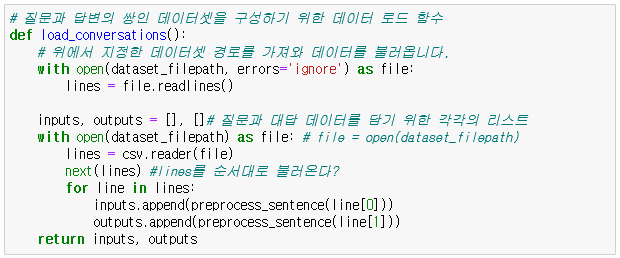



---




# 🖇️ 참고 페이지

### load_conversations 함수 이해하기 및 기타 등등
[강양인 김유식님 프로젝트](https://github.com/MulderKim/EXPLORATION/blob/main/15/transformer_chatbot.ipynb) 


### 추후에 공부 할 때 참고하면 좋을 페이지



[트랜스포머 관련](https://wikidocs.net/31379)


[트랜스포머 관련 2](https://nlpinkorean.github.io/illustrated-transformer/)


[한국어 데이터로 챗봇 만들기 2](https://wikidocs.net/89786)